# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

In [4]:
#!g1.1
# from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn

from typing import Tuple, Callable
from torch import Tensor

In [5]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

In [10]:
from natsort import natsorted
import re
from PIL import Image

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='/mnt/e/it/shad/2023s_gm/data/celeba', transform=None, attr_index=None):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        self.dataset_folder = os.path.abspath(f'{root_dir}/img_align_celeba/')
        self.transform = transform 
        
        image_names = os.listdir(self.dataset_folder)
        image_names = natsorted(image_names)
        
        filenames = []
        # annotations = []
        with open(f'{root_dir}/list_attr_celeba.txt') as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    self.header = re.split(' +', line)
                else:
                    values = re.split(' +', line)
                    filename = values[0]
                    filenames.append(filename)
                    # annotations.append([int(v) for v in values[1:]])
        
        self.filenames = []
        
        max_size = 50000
        max_size = 1000
        
        for filename in filenames:
            self.filenames.append(filename)

            if len(self.filenames) >= max_size:
                break
        
        self.images = []
        for i in tqdm(range(len(self))):
            img_name = self.filenames[i]
            img_path = os.path.join(self.dataset_folder, img_name)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
                
            self.images.append(img)     
            
    def __len__(self): 
        return len(self.filenames)

    def __getitem__(self, idx):
        return self.images[idx] #, self.annotations[idx]

In [11]:
dataset = CelebADataset(transform=transform)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
img = dataset[0]
img.shape, img.min(), img.max()

(torch.Size([3, 64, 64]), tensor(-1.), tensor(1.))

### Визуализация датасета

In [13]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

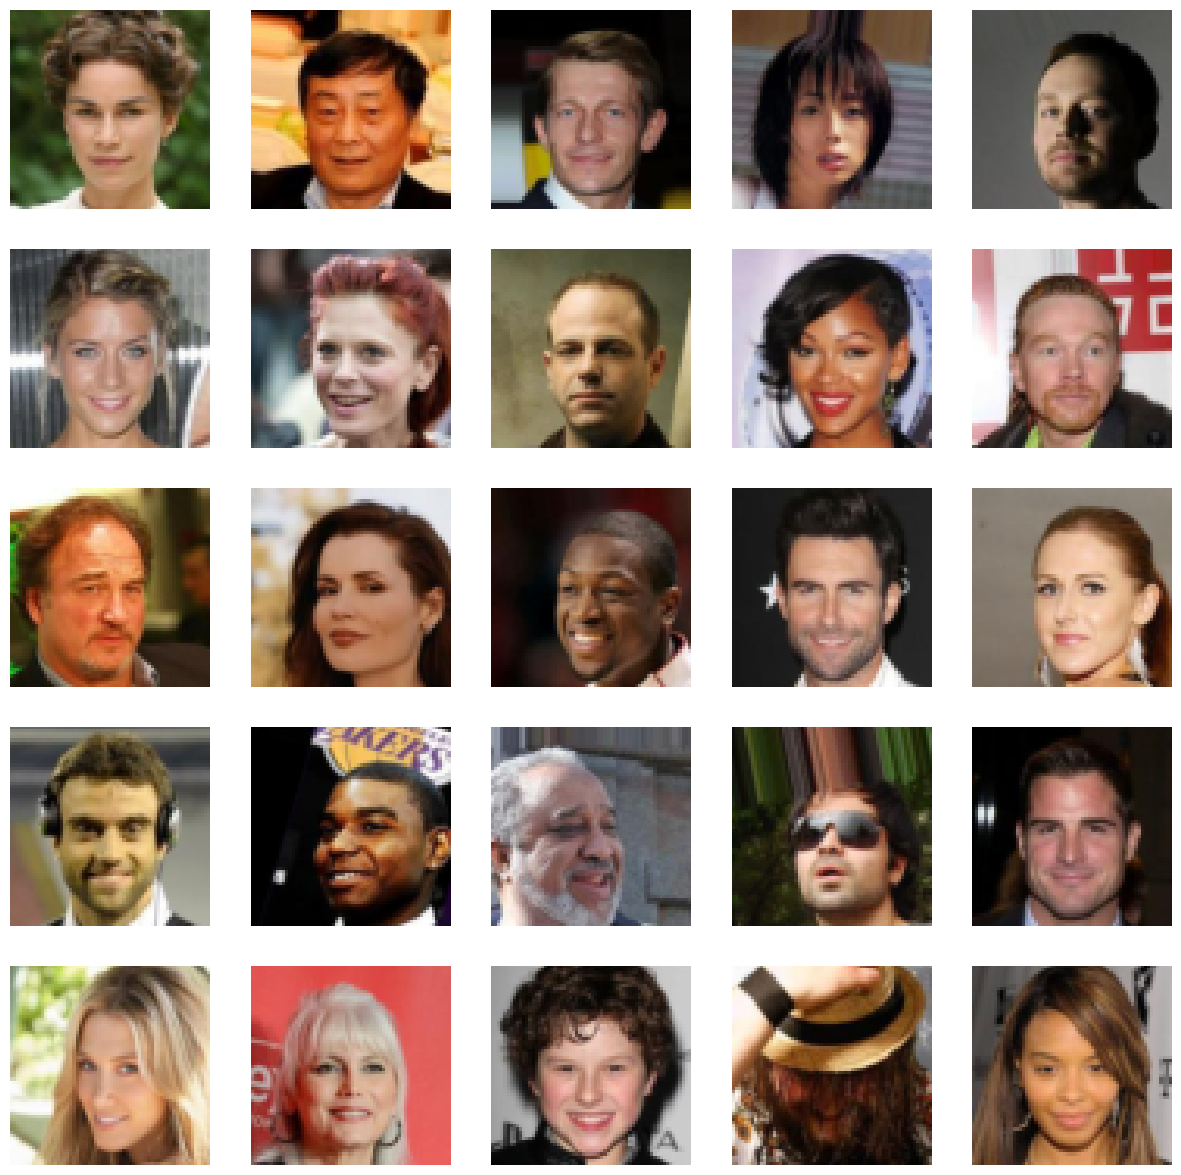

In [14]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

In [15]:
# YOUR CODE HERE

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [16]:
# YOUR CODE HERE

In [17]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, upsample = False):
        super().__init__()
        if not upsample:
            self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor) -> Tensor:
        return self.act(self.bn(self.conv(x)))


class Vae(nn.Module):
    def __init__(self, h = 32):
        super().__init__()
        
        self.latent_dim = 128
        c = 3
        
        self.encoder = nn.Sequential(
            Block(c, h),   # [32, 32]
            Block(h, 2 * h),        # [16, 16]
            Block(2 * h, 4 * h),    # [8, 8]
            Block(4 * h, 8 * h),    # [4, 4]
            Block(8 * h, 16 * h),   # [2, 2]
            nn.Flatten(),           # [4 * 16 * h]
            nn.Linear(4 * 16 * h, 2 * self.latent_dim),  # [2 * latent_dim]
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 4 * 16 * h),   # [4 * 16 * h]
            nn.Unflatten(1, (16 * h, 2, 2)),          # [2, 2]
            Block(16 * h, 8 * h, True), # [4, 4]
            Block(8 * h, 4 * h, True),  # [8, 8]
            Block(4 * h, 2 * h, True),  # [16, 16]
            Block(2 * h, h, True),      # [32, 32]
            Block(h, h, True),          # [64, 64]
            nn.Conv2d(h, out_channels=c, kernel_size=3, padding=1),  # [64, 64]
            nn.Tanh(),
        )

    def encode(self, x: Tensor):
        latent = self.encoder(x)
        mu, log_sigma = latent.chunk(2, dim=1)
        
        return mu, log_sigma

    def decode(self, z: Tensor):
        return self.decoder(z)

    def forward(self, x: Tensor):
        mu, log_sigma = self.encode(x)
        z = mu + torch.exp(0.5 * log_sigma) * torch.randn_like(log_sigma)
        
        rec = self.decode(z)
        return rec, z, mu, log_sigma

In [18]:
def vae_loss(x, rec, mu, log_sigma):
    reconstruction_loss = F.mse_loss(x, rec)

    kld_loss = (0.5 * (torch.exp(2 * log_sigma) + mu**2 - 2 * log_sigma - 1)).sum(dim=1).mean()

    loss = reconstruction_loss + 2e-4 * kld_loss
    return loss

def vae_train_step(vae_model, images):
    rec, z, mu, log_sigma = vae_model(images)
    loss = vae_loss(images, rec, mu, log_sigma)
    return loss

In [19]:
def train(model, dataloader, train_step_func, device, n_epochs, lr, lr_decay):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

    os.makedirs('checkpoints')

    losses = []
    for e in trange(n_epochs):
        model.train()

        for images in tqdm(dataloader, leave=False):
            images = images.to(device)
            loss = train_step_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            losses.append(loss.item())

        torch.save(model.state_dict(), os.path.join('checkpoints', f"epoch_{e + 1}.ckpt"))

        scheduler.step()

    return losses

In [20]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [21]:
vae_celeba_dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
vae_celeba = Vae().to(device)

vae_celeba.load_state_dict(torch.load('vae.ckpt'))

# vae_losses = train(
#     vae_celeba, vae_celeba_dataloader, vae_train_step, device, n_epochs=30, lr=0.001, lr_decay=0.99
# )

<All keys matched successfully>

In [22]:
# !pip install torchmetrics
# !pip install torchmetrics[image]
# !pip install torch-fidelity

from torchmetrics.image.fid import FrechetInceptionDistance

batch_size = 100
dataset_size = 5 * batch_size

fid = FrechetInceptionDistance(64)

with torch.no_grad():    
    vae_celeba.eval()

    for real_images in tqdm(torch.utils.data.DataLoader(dataset[:dataset_size], batch_size=batch_size)):
        real_images = (real_images * 255).byte()
        fid.update(real_images, real=True)
    
    for _ in trange(dataset_size // batch_size):
        fake_batch = torch.randn(batch_size, vae_celeba.latent_dim, device=device)

        fake_images = vae_celeba.decode(fake_batch).detach().cpu()
        fake_images = (fake_images * 255).byte()
        fid.update(fake_images, real=False)

fid.compute().item()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

3.1691324710845947

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

decode noise

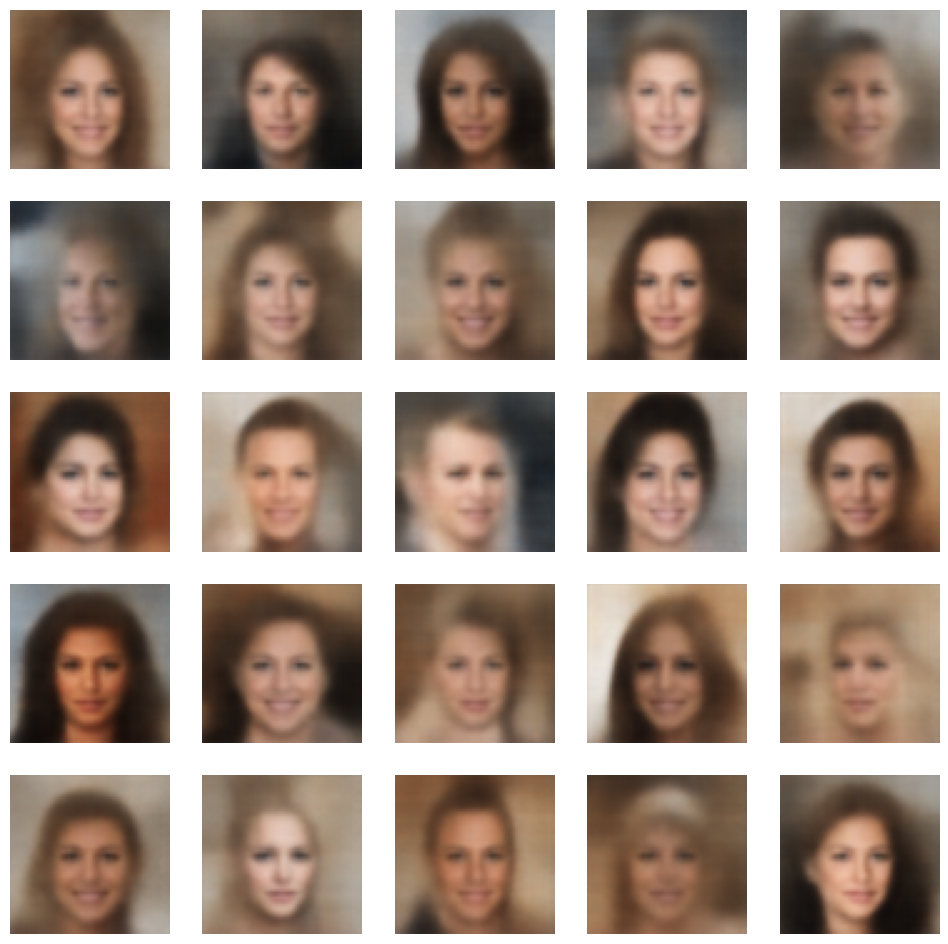

In [23]:
latent_noise = torch.randn(100, vae_celeba.latent_dim, device=device)

plt.figure(figsize=(12, 12))
for i, img in enumerate(vae_celeba.decode(latent_noise).detach().cpu()[:25]):
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)

plt.savefig('decode_noise.png', bbox_inches="tight")
plt.show()

encode-decode

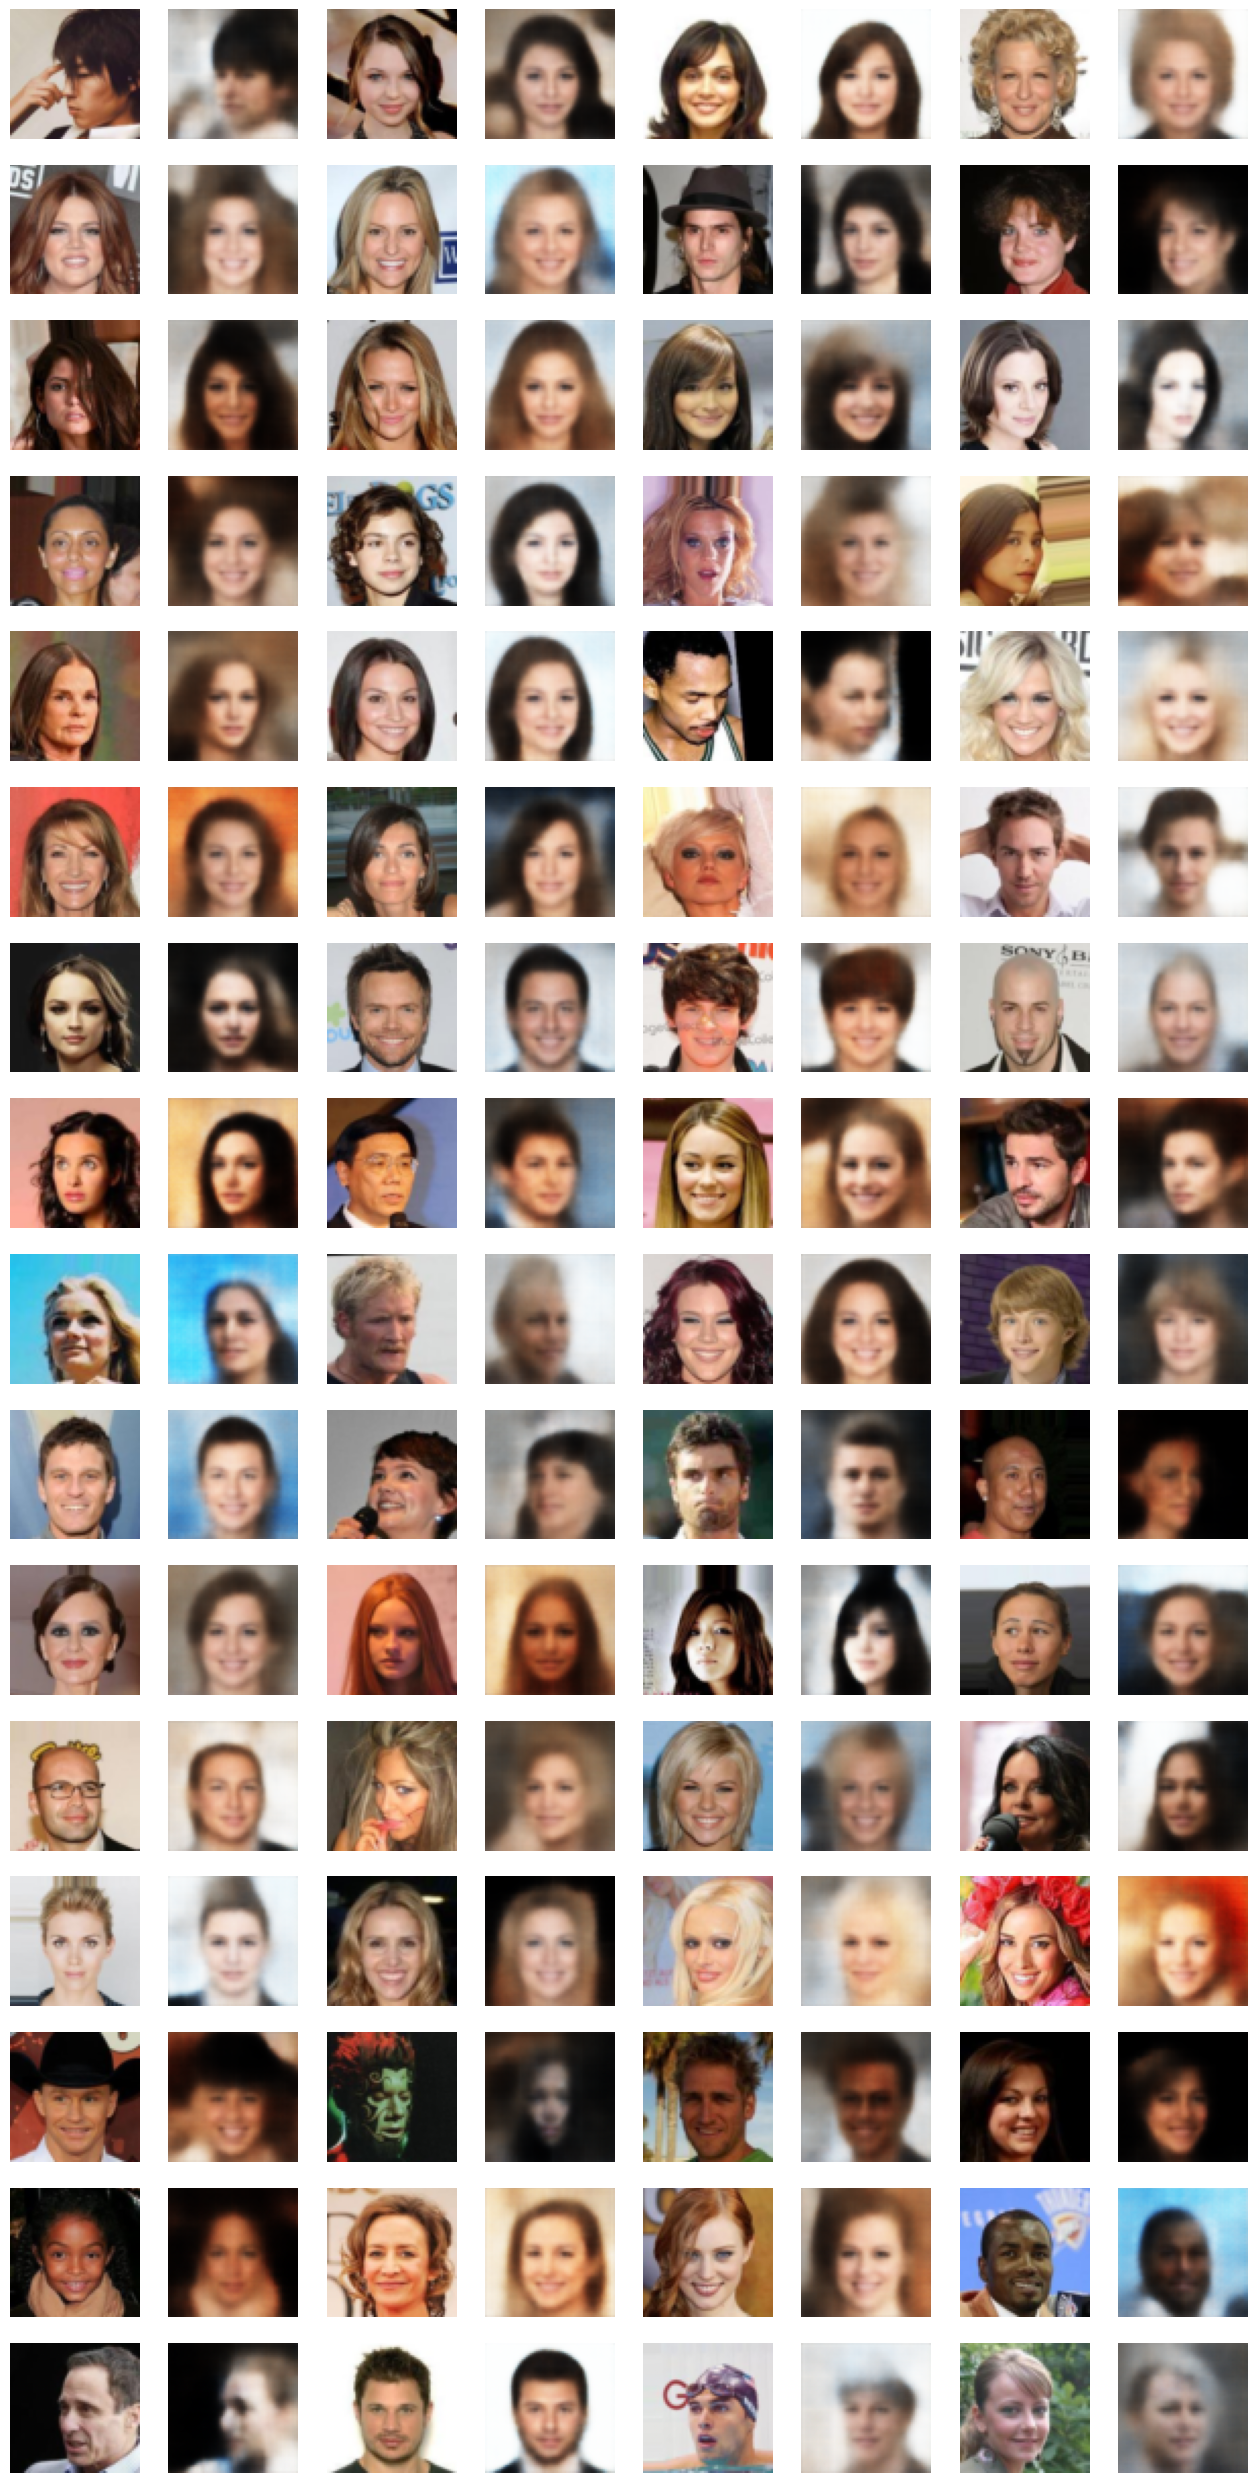

In [213]:
n_images = 128

orig_images = [dataset[np.random.randint(len(dataset))] for _ in range(n_images // 2)]

vae_celeba.eval()
with torch.no_grad():
    rec, z, _, _ = vae_celeba(torch.stack(orig_images).to(device))
    rec_images = vae_celeba.decode(z).detach().cpu()
    # rec_images = rec.detach().cpu()

images = []
for a, b in zip(orig_images, rec_images):
    images += [a, b]

    
plt.figure(figsize=(16, n_images // 4))

for i, img in enumerate(images):
    plt.subplot(n_images // 8, 8, i + 1)
    plot_img(img, t_invnormalize)

plt.savefig('encode_decode.png', bbox_inches="tight")
plt.show()

interpolation

  0%|          | 0/8 [00:00<?, ?it/s]

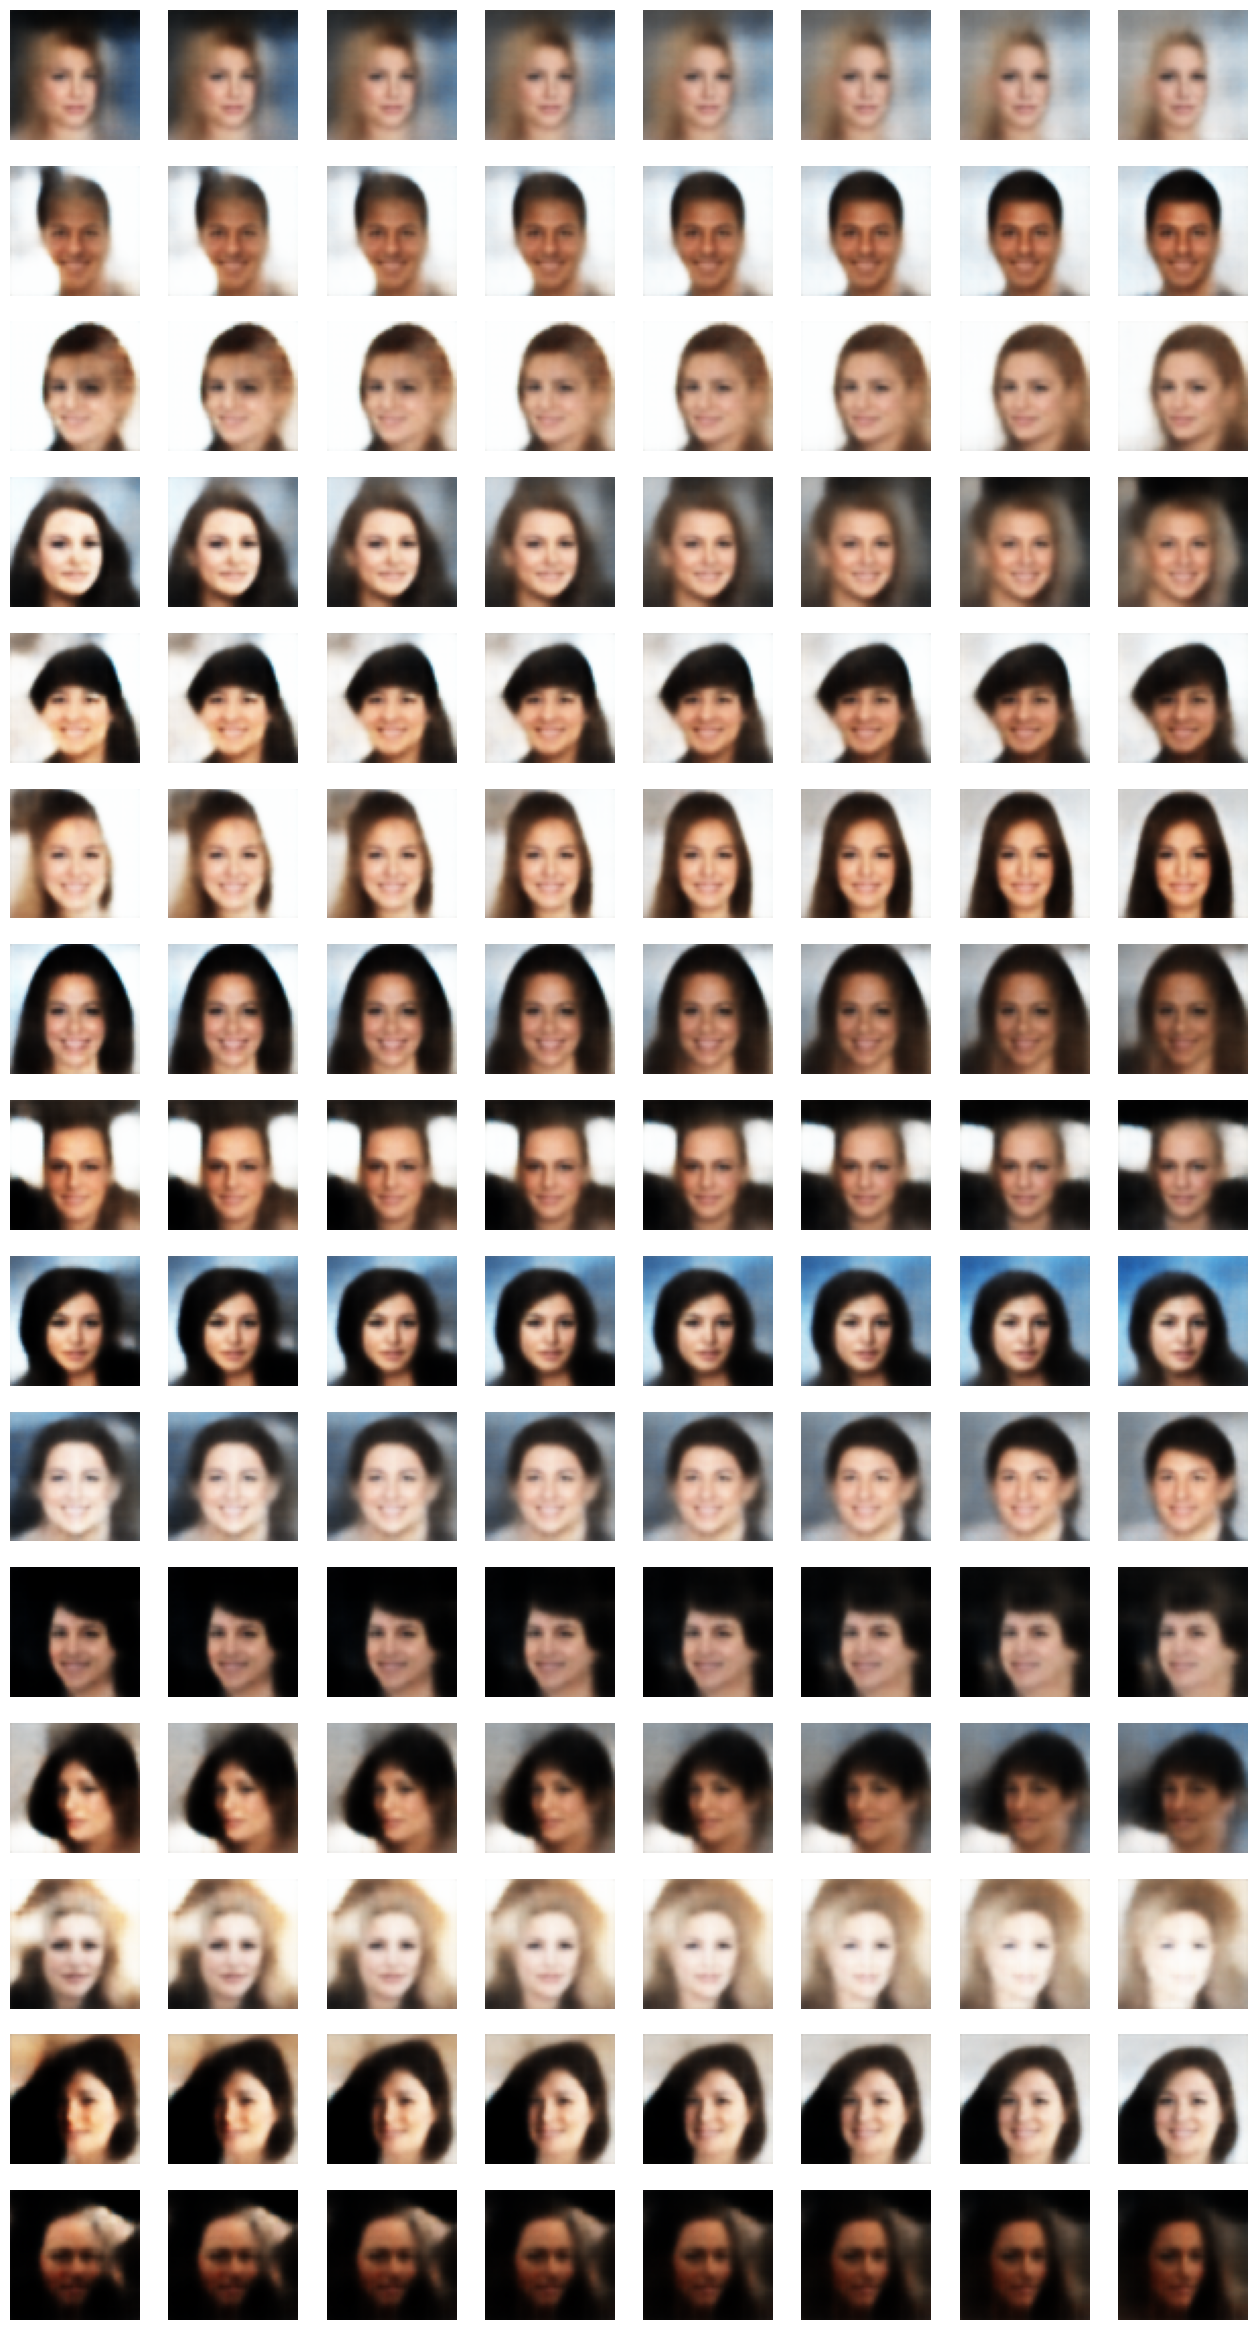

In [224]:
n_images = 30
n_steps = 8

orig_images = [dataset[np.random.randint(len(dataset))] for _ in range(n_images)]

vae_celeba.eval()
with torch.no_grad():
    batch = torch.stack(orig_images)
    _, edge_z, _, _ = vae_celeba(batch.to(device))

images = []
with torch.no_grad():
    for i in tqdm(range(0, n_steps)):
        inter_z = edge_z[:n_images // 2] + (edge_z[n_images // 2:] - i / (n_steps - 1) * edge_z[:n_images // 2])
        img = vae_celeba.decode(inter_z)
        images.extend(img)

transpose_images = [images[t * n_images // 2 + i] for i in range(n_images // 2) for t in range(n_steps)]


plt.figure(figsize=(16, n_images))

for i, img in enumerate(transpose_images):
    plt.subplot(n_images // 2, n_steps, i + 1)
    plot_img(img.detach().cpu(), t_invnormalize)

plt.savefig('interpolation.png', bbox_inches="tight")
plt.show()

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.